In [1]:
from __future__ import annotations
from dataclasses import dataclass

import jax
import jax.numpy as jnp
from jax.tree_util import register_dataclass
import jaxtyping

import hodel.dismech as dismech

jax.config.update("jax_enable_x64", True)

geom = dismech.Geometry(
    rod_r0=0.001,
    shell_h=0,
)

mat = dismech.Material(
    density=1200,
    youngs_rod=2e6,
    youngs_shell=0,
    poisson_rod=0.5,
    poisson_shell=0,
)

"""# TODO: Figure out how sim params works for HoDEL
sim_params = dismech.SimParams(
    max_iter=30,
    tol=1e-4,
    ftol=1e-4,
    dtol=1e-2,
)"""


@register_dataclass
@dataclass(frozen=True)
class ScaledTriplet(dismech.Triplet):
    def get_K(self, del_strain: jax.Array, Theta: jaxtyping.PyTree) -> jax.Array:
        K_min = jnp.array([1, 1, 1e-7, 1e-7, 1e-7])
        K_max = jnp.array([10, 10, 1e-5, 1e-5, 1e-5])

        # Smooth bounded mapping to [K_min, K_max]
        K_diag = K_min + (K_max - K_min) * jax.nn.softplus(Theta)
        # jax.debug.print("{}", K_diag)
        return jnp.diag(K_diag)


mesh = dismech.Mesh.from_txt("rod.txt")
top, state, mass, theta, triplets = dismech.from_legacy_custom(
    mesh, geom, mat, ScaledTriplet
)
_, _, _, truth_triplets, _ = dismech.from_legacy(mesh, geom, mat)

assert type(triplets) is ScaledTriplet
assert type(truth_triplets) is dismech.DERTriplet

In [2]:
from dataclasses import dataclass
from jax.tree_util import register_dataclass

import hodel


def get_indices(
    q: jax.Array,
    top: dismech.Connectivity,
    fixed_nodes: jax.Array | None = None,
    fixed_edges: jax.Array | None = None,
) -> tuple[jax.Array, jax.Array]:
    nodes = (
        jnp.array([]) if fixed_nodes is None else dismech.map_node_to_dof(fixed_nodes)
    )
    edges = jnp.array([]) if fixed_edges is None else top.edge_dofs[0] + fixed_edges
    idx_b = jnp.union1d(nodes, edges)
    return idx_b, jnp.setdiff1d(jnp.arange(q.shape[0]), idx_b)


idx_b, idx_f = get_indices(
    state.q, top, jnp.array([0, 1, 2, 18, 19, 20]), jnp.array([0, 1, 18, 19])
)


@register_dataclass
@dataclass(frozen=True)
class TripletAux:
    """parametrized external force."""

    top: dismech.Connectivity  # for state.update()
    idx_f: jax.Array
    idx_b: jax.Array


def get_gravity(mass: jax.Array, g: jax.Array = jnp.array([0.0, 0.0, -9.81])):
    return mass * jnp.concat(
        [
            jnp.tile(g, mesh.nodes.shape[0]),
            jnp.zeros(mesh.edges.shape[0]),
        ]
    )


def get_W(lambda_: jax.Array, aux: TripletAux):
    """Just gravity."""
    return get_gravity(mass)[aux.idx_f]


def fixed_0(lambda_: jax.Array, aux: TripletAux) -> jax.Array:
    """Compress and contort."""
    return state.q[aux.idx_b] + lambda_ * jnp.concat(
        [
            jnp.array([0.02, 0.0, 0, 0.02, 0.0, 0, 0.02, 0.0, 0]),
            jnp.zeros(aux.idx_b.shape[0] - 13),
            jnp.array([1.0, 1.0, 0.0, 0.0]),
        ]
    )


def get_q(xf: jax.Array, xb: jax.Array, aux: TripletAux) -> jax.Array:
    """Helper to construct q from xf and xb."""
    q = jnp.empty((aux.idx_f.shape[0] + aux.idx_b.shape[0]), xf.dtype)
    return q.at[aux.idx_f].set(xf).at[aux.idx_b].set(xb)


def update_state(
    xf: jax.Array, xb: jax.Array, aux: TripletAux, carry: dismech.StaticState
) -> dismech.StaticState:
    """Construct q from xf and xb and update state."""
    q = get_q(xf, xb, aux)
    carry_new = carry.update(q, aux.top)
    return carry_new

def get_energy_fn(triplets):
    def get_batch_energy(
        xf: jax.Array,
        xb: jax.Array,
        Theta: jaxtyping.PyTree,
        aux: TripletAux,
        carry: dismech.StaticState,
    ) -> jax.Array:
        q = get_q(xf, xb, aux)
        state = carry.update(q, aux.top)
        return jnp.sum(jax.vmap(lambda t: t.get_energy(state, Theta))(triplets))
    return get_batch_energy

xf0 = state.q[idx_f]
aux = TripletAux(top, idx_f, idx_b)
sim = hodel.HODEL(
    get_energy_fn(triplets), get_W_fn=get_W, get_xb_fn=fixed_0, carry_fn=update_state
)
truth_sim = hodel.HODEL(
    get_energy_fn(truth_triplets), get_W_fn=get_W, get_xb_fn=fixed_0, carry_fn=update_state
)

In [3]:
lambdas = jnp.linspace(0, 1.0, 100)
xf_stars = truth_sim.solve(lambdas, xf0, None, aux, state, nsteps=10)
xb_stars = jax.vmap(fixed_0, (0, None))(lambdas, aux)
qs = jax.vmap(get_q, (0, 0, None))(xf_stars, xb_stars, aux)
dismech.animate(lambdas, qs, top)

In [4]:
key = jax.random.PRNGKey(0)
Theta0 = jax.random.uniform(key, [5])
lambdas = jnp.linspace(0, 1.0, 100)
xf_theta0 = sim.solve(lambdas, xf0, Theta0, aux, state, nsteps=10)
qs = jax.vmap(get_q, (0, 0, None))(xf_theta0, xb_stars, aux)
dismech.animate(lambdas, qs, top)

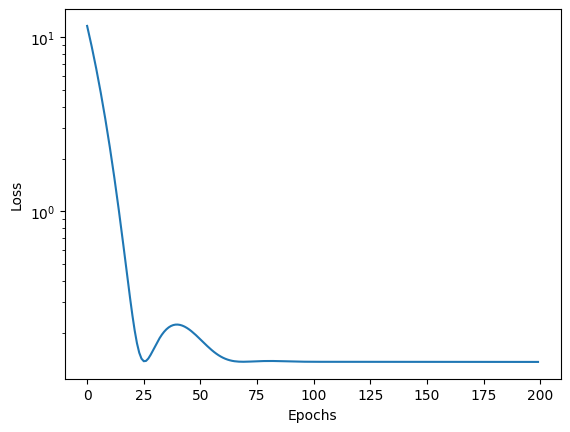

True Theta: [6.28318531e+00 6.28318531e+00 1.57079633e-06 1.57079633e-06
 1.04719755e-06]
Theta0: [9.31695554e+00 8.26418358e+00 1.28514821e-05 1.02088764e-05
 9.94315785e-06]
Final Theta: [6.61671506e+00 5.84066471e+00 1.15069753e-05 1.14747991e-05
 1.12918367e-05]


In [ ]:
import optax
import matplotlib.pyplot as plt

lambdas = jnp.linspace(0, 1, 100)
key = jax.random.PRNGKey(0)
Theta0 = jax.random.uniform(key, [5])
lr = 1e-2
nepochs = 200


final_Theta, L = sim.learn(
    lambdas,
    xf0,
    xf_stars,
    Theta0,
    aux,
    state,
    # batch_size=2,
    optim=optax.adam(lr),
    nepochs=nepochs,
)

plt.plot(L)
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

print("True Theta:", theta)
print("Theta0:", jnp.diag(triplets.get_K(jnp.array([]), Theta0)))
print("Final Theta:", jnp.diag(triplets.get_K(jnp.array([]), final_Theta)))

In [10]:
lambdas = jnp.linspace(0, 1.0, 100)
xf_test = sim.solve(lambdas, xf0, final_Theta, aux, state, nsteps=10)
xb_star = jax.vmap(fixed_0, (0, None))(lambdas, aux)
qs = jax.vmap(get_q, (0, 0, None))(xf_test, xb_star, aux)
dismech.animate(lambdas, qs, top)